# **CS224W: Final Project**
# Graph WaveNet for Deep Spatial-Temporal Graph Modeling

Spatial-temporal graph modeling is a technique used to analyze and understand complex systems, particularly those with varying behaviors across both spatial (how different components or nodes are related in space) and temporal (how these relationships change over time) dimensions. With the advent of graph neural networks, spatial-temporal graph modeling has received increased attention due to its applicability in diverse problem spaces, encompassing areas like traffic speed forecasting, taxi demand prediction, human action recognition, and more.

However, capturing spatial and temporal dependencies simultaneously can be challenging. Recent research has explored integrating graph convolution networks (GCN) into either a recurrent neural network (RNN) or a convolutional neural network (CNN). However, these approaches have drawbacks. The GCN assumes that the predefined graph structure accurately represents genuine dependency relationships, overlooking nuanced situations where connections do not imply true inter-dependencies. Also, capturing temporal dependencies with RNNs or CNNs can be slow and computationally inefficient when considering longer sequences. 

We introduce the Graph WaveNet framework to tackle these shortcomings and effectively represent Spatial-temporal graphs using Graph Wavenet Framework to forecast the future.

# Installation

In [82]:
# Install torch geometric
import os
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip3 install torch-scatter -f $scatter_src
!pip3 install torch-sparse -f $sparse_src
!pip3 install torch-geometric
!pip3 install -q git+https://github.com/snap-stanford/deepsnap.git
!pip3 install -U -q PyDrive

!python3 -c "import torch; print(torch.version.cuda)"

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1.html

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1.html

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
None


In [83]:
import torch
print(torch.__version__)
import torch_geometric
print(torch_geometric.__version__)

1.13.1
2.4.0


## Graph WaveNet Framework - Our Implementation
Our implementation of Graph WaveNet Framework is located at https://github.com/ggaoshen/graph_wavenet.git. We import the `GraphWaveNet` model from our repo and load it to the Colab.

In [84]:
# Import GraphWaveNet module
!git clone https://github.com/ggaoshen/graph_wavenet.git
%load graph_wavenet/src/graphwavenet.py
import sys
sys.path.append('graph_wavenet/src/')
from graphwavenet import GraphWaveNet
import util as util
from util import masked_mse, temporal_dataset_split

## PyTorch Geometric Temporal
PyTorch Geometric Temporal is a temporal graph neural network extension library for PyTorch Geometric. It builds on open-source deep-learning and graph processing libraries. It is the first open-source library for temporal deep learning on geometric structures and provides constant time difference graph neural networks on dynamic and static graphs.
We install the PGT library to gain access to its strucures, functions and datasets.

In [85]:
!pip3 install -U torch-geometric-temporal


[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip


## Hungarian Chickenpox Dataset
PyTorch Geometric Temporal (PGT) provides the Chickenpox Cases in Hungary dataset, which shares the reported cases of chickenpox in Hungary by county on a weekly basis between 2005 and 2015, with (20) nodes representing counties and (61) undirected edges representing a “neighboring” relationship.  This is an example of a static graph with temporal signals.  The graph structure represents the regional geography, which is fixed, while the node features represent the number of cases of the disease, which varies over time. Further information on the dataset and its significance can be found at https://arxiv.org/abs/2102.08100.

This colab will use our Graph WaveNet Framework to represent the Hungarian Chickenpox Dataset and learn to predict cases over a 10 week forecast. To do so, we download the dataset from PGT below.

In [86]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
dataset = ChickenpoxDatasetLoader().get_dataset(lags=8) # consistent with chickenpox paper
iterator = iter(dataset)
print("ChickenpoxDatasetLoader", next(iterator))
print("ChickenpoxDatasetLoader", next(iterator))

ChickenpoxDatasetLoader Data(x=[20, 8], edge_index=[2, 102], edge_attr=[102], y=[20])
ChickenpoxDatasetLoader Data(x=[20, 8], edge_index=[2, 102], edge_attr=[102], y=[20])


Import all the necessary PyTorch libraries for training the Graph WaveNet Framework.

In [104]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

# training
from tqdm import tqdm
import time
from torch_geometric_temporal.signal import temporal_signal_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() # clear cuda cache

#### Temporal Signal Split
This is an essential feature provided by PGT that helps to break the down in to training, validation, and testing datasets along the temporal dimension.

In [105]:
train_ratio, val_ratio = 0.7, 0.1
train_dataset, val_dataset, test_dataset = temporal_dataset_split(dataset, train_split = train_ratio, validation_split = val_ratio)
val_offset = int(dataset.snapshot_count * train_ratio) # starting index for valid set
test_offset = val_offset+int(dataset.snapshot_count * val_ratio) # starting index for valid set

def prepare_n_period_y(dataset):

    res = []
    for data in dataset:
        res.append(data.y)
    res = torch.stack(res, dim=0)

    return res

y_all = prepare_n_period_y(dataset)

In [106]:
in_dim = dataset[0].num_node_features # 8 treat lagged inputs as node features
out_dim = 1
num_nodes = dataset[0].num_nodes # 20
timesteps_to_predict = 10 # 10, 20, 40 week forecast horizon
epochs = 200
lrate = 0.0001
wdecay = 0.001

# early stopping parameters
patience = 10
counter = 0
best_val_loss = float('inf') 

save_path = "store/checkpoint"
if not os.path.exists(save_path):
    os.makedirs(save_path)

## Graph Wavenet - Extension
To further improve our Graph WaveNet Framework, we introduced an extension framework to boost its performace while training on the Hungrarian Small Pox data set. Some key etension features include adding skip connections within the spatial temporal layers and introducing a learning rate decay scheduler.
`util.extensions_enabled` flag controls the enablement of extensions.

In [107]:
# util.extensions_enabled controls the extensions that have been introduced to improve 
# the performance of Graph Wavenet. To turn off the extensions, set the below flag to False
util.extensions_enabled = True
print("Graph Wavenet - Extensions Enabled: {}".format(util.extensions_enabled))
if util.extensions_enabled:
    epochs = 50

Graph Wavenet - Extensions Enabled: True


#### GraphWaveNet
This is our implementation of the framework.

In [108]:
model = GraphWaveNet(
    num_nodes=num_nodes,
    in_channels=in_dim,
    out_channels=out_dim,
    out_timesteps=timesteps_to_predict,
).to(device)

#### Graph WaveNet Training

In [109]:
print("start training...", flush=True)
his_loss = []
val_time = []
train_time = []
best_epoch = 0

optimizer = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)

scheduler = None
clip = None

# As part of extensions, we enable learning rate decay and gradient clipping
if util.extensions_enabled:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)
    clip = 5

model.train()

training_curve_dict = {"epoch_train_loss": [], "epoch_valid_loss": []}

for epoch in tqdm(range(epochs)):
    train_loss = []
    t1 = time.time()

    for i, snapshot in enumerate(train_dataset):
        x_train = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)
        if timesteps_to_predict == 1:
            y_train = snapshot.y.to(device)
        else:
            y_train = y_all[i : i + timesteps_to_predict,:].to(device)

        pred = model(x_train, snapshot.edge_index, snapshot.edge_attr).squeeze()
        loss = masked_mse(pred, y_train, 0.0) # mean squared error for loss
        loss.backward()
        if util.extensions_enabled:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if util.extensions_enabled:
            scheduler.step()

        optimizer.zero_grad()

        train_loss.append(loss.item())

    mtrain_loss = np.mean(train_loss)
    training_curve_dict['epoch_train_loss'].append(mtrain_loss)
    print(f"training loss: {mtrain_loss}")


    t2 = time.time()
    train_time.append(t2 - t1)
    valid_loss = []

    s1 = time.time()
    for i, snapshot in enumerate(val_dataset):
        x_val = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)
        if timesteps_to_predict == 1:
            y_val = snapshot.y.to(device)
        else:
            y_val = y_all[val_offset + i : val_offset + i + timesteps_to_predict,:].to(device)

        with torch.no_grad():
            pred = model(x_val, snapshot.edge_index, snapshot.edge_attr).squeeze()
        loss = masked_mse(pred, y_val, 0.0).cpu().numpy()
        valid_loss.append(loss)

    s2 = time.time()
    # log = "Epoch: {:03d}, Inference Time: {:.4f} secs"
    # print(log.format(i, (s2 - s1)))
    val_time.append(s2 - s1)

    mvalid_loss = np.mean(valid_loss)
    training_curve_dict['epoch_valid_loss'].append(mvalid_loss)

    his_loss.append(mvalid_loss)

    if np.argmin(his_loss) == len(his_loss) - 1:
        torch.save(
            model.state_dict(), save_path + "/epoch_" + str(i) + ".pth"
        )
        best_epoch = i

    log = (
        "Epoch: {:03d}, Train Loss: {:.4f}, "
        + "Valid Loss: {:.4f}, "
        + "Training Time: {:.4f}/epoch"
    )
    print(
        log.format(
            i,
            mtrain_loss,
            mvalid_loss,
            (t2 - t1),
        ),
        flush=True,
    )
print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))


start training...


  0%|          | 0/50 [00:00<?, ?it/s]

training loss: 0.9927649475416184
Epoch: 050, Train Loss: 0.9928, Valid Loss: 0.8144, Training Time: 9.2988/epoch


  2%|▏         | 1/50 [00:09<08:04,  9.88s/it]

training loss: 0.9743932186675188
Epoch: 050, Train Loss: 0.9744, Valid Loss: 0.8099, Training Time: 9.1238/epoch


  4%|▍         | 2/50 [00:19<07:49,  9.79s/it]

training loss: 0.9668276639017056
Epoch: 050, Train Loss: 0.9668, Valid Loss: 0.8079, Training Time: 9.5505/epoch


  6%|▌         | 3/50 [00:29<07:49,  9.98s/it]

training loss: 0.9631220695762415
Epoch: 050, Train Loss: 0.9631, Valid Loss: 0.8075, Training Time: 9.1801/epoch


  8%|▊         | 4/50 [00:39<07:36,  9.92s/it]

training loss: 0.9605597644048149
Epoch: 050, Train Loss: 0.9606, Valid Loss: 0.8071, Training Time: 9.4127/epoch


 10%|█         | 5/50 [00:49<07:27,  9.94s/it]

training loss: 0.9587598632668303
Epoch: 050, Train Loss: 0.9588, Valid Loss: 0.8056, Training Time: 9.0638/epoch


 12%|█▏        | 6/50 [00:59<07:13,  9.84s/it]

training loss: 0.9570951011177142
Epoch: 050, Train Loss: 0.9571, Valid Loss: 0.8061, Training Time: 9.0275/epoch


 14%|█▍        | 7/50 [01:08<06:59,  9.77s/it]

training loss: 0.9570089809254102
Epoch: 050, Train Loss: 0.9570, Valid Loss: 0.8065, Training Time: 9.0222/epoch


 16%|█▌        | 8/50 [01:18<06:47,  9.71s/it]

training loss: 0.9561041787079948
Epoch: 050, Train Loss: 0.9561, Valid Loss: 0.8063, Training Time: 9.2075/epoch


 18%|█▊        | 9/50 [01:28<06:39,  9.75s/it]

training loss: 0.9561237550410636
Epoch: 050, Train Loss: 0.9561, Valid Loss: 0.8058, Training Time: 9.2672/epoch


 20%|██        | 10/50 [01:38<06:31,  9.78s/it]

training loss: 0.9550637062120155
Epoch: 050, Train Loss: 0.9551, Valid Loss: 0.8051, Training Time: 9.3476/epoch


 22%|██▏       | 11/50 [01:48<06:23,  9.84s/it]

training loss: 0.9556152909672443
Epoch: 050, Train Loss: 0.9556, Valid Loss: 0.8056, Training Time: 9.3790/epoch


 24%|██▍       | 12/50 [01:58<06:15,  9.87s/it]

training loss: 0.9551728466593123
Epoch: 050, Train Loss: 0.9552, Valid Loss: 0.8051, Training Time: 9.0643/epoch


 26%|██▌       | 13/50 [02:07<06:02,  9.80s/it]

training loss: 0.9545262028777085
Epoch: 050, Train Loss: 0.9545, Valid Loss: 0.8053, Training Time: 9.3837/epoch


 28%|██▊       | 14/50 [02:17<05:54,  9.85s/it]

training loss: 0.9546635651903896
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8058, Training Time: 9.1056/epoch


 30%|███       | 15/50 [02:27<05:43,  9.80s/it]

training loss: 0.9548705985826702
Epoch: 050, Train Loss: 0.9549, Valid Loss: 0.8060, Training Time: 9.3074/epoch


 32%|███▏      | 16/50 [02:37<05:34,  9.84s/it]

training loss: 0.9546551536042295
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8061, Training Time: 9.1902/epoch


 34%|███▍      | 17/50 [02:47<05:24,  9.83s/it]

training loss: 0.9547218771542431
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8054, Training Time: 9.2761/epoch


 36%|███▌      | 18/50 [02:57<05:15,  9.85s/it]

training loss: 0.9546897810336441
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8054, Training Time: 9.1391/epoch


 38%|███▊      | 19/50 [03:06<05:04,  9.82s/it]

training loss: 0.9549726633806415
Epoch: 050, Train Loss: 0.9550, Valid Loss: 0.8062, Training Time: 9.2131/epoch


 40%|████      | 20/50 [03:16<04:54,  9.81s/it]

training loss: 0.9545375569191733
Epoch: 050, Train Loss: 0.9545, Valid Loss: 0.8056, Training Time: 9.2047/epoch


 42%|████▏     | 21/50 [03:26<04:44,  9.81s/it]

training loss: 0.9544355299707741
Epoch: 050, Train Loss: 0.9544, Valid Loss: 0.8069, Training Time: 9.0966/epoch


 44%|████▍     | 22/50 [03:36<04:33,  9.77s/it]

training loss: 0.9549561853320818
Epoch: 050, Train Loss: 0.9550, Valid Loss: 0.8047, Training Time: 9.3393/epoch


 46%|████▌     | 23/50 [03:45<04:25,  9.82s/it]

training loss: 0.954543543242769
Epoch: 050, Train Loss: 0.9545, Valid Loss: 0.8061, Training Time: 9.1239/epoch


 48%|████▊     | 24/50 [03:55<04:14,  9.79s/it]

training loss: 0.9546057310027997
Epoch: 050, Train Loss: 0.9546, Valid Loss: 0.8053, Training Time: 9.1158/epoch


 50%|█████     | 25/50 [04:05<04:03,  9.76s/it]

training loss: 0.9546843269647911
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8060, Training Time: 9.1143/epoch


 52%|█████▏    | 26/50 [04:15<03:53,  9.75s/it]

training loss: 0.9547584872474909
Epoch: 050, Train Loss: 0.9548, Valid Loss: 0.8058, Training Time: 9.1017/epoch


 54%|█████▍    | 27/50 [04:24<03:43,  9.73s/it]

training loss: 0.9545209251894177
Epoch: 050, Train Loss: 0.9545, Valid Loss: 0.8067, Training Time: 9.1591/epoch


 56%|█████▌    | 28/50 [04:34<03:34,  9.73s/it]

training loss: 0.9546491822336792
Epoch: 050, Train Loss: 0.9546, Valid Loss: 0.8054, Training Time: 9.1188/epoch


 58%|█████▊    | 29/50 [04:44<03:24,  9.72s/it]

training loss: 0.9548923716229234
Epoch: 050, Train Loss: 0.9549, Valid Loss: 0.8058, Training Time: 9.1218/epoch


 60%|██████    | 30/50 [04:53<03:14,  9.72s/it]

training loss: 0.9548580821105448
Epoch: 050, Train Loss: 0.9549, Valid Loss: 0.8057, Training Time: 9.1164/epoch


 62%|██████▏   | 31/50 [05:03<03:04,  9.71s/it]

training loss: 0.9550976565361936
Epoch: 050, Train Loss: 0.9551, Valid Loss: 0.8059, Training Time: 9.1073/epoch


 64%|██████▍   | 32/50 [05:13<02:54,  9.71s/it]

training loss: 0.9541633569772944
Epoch: 050, Train Loss: 0.9542, Valid Loss: 0.8053, Training Time: 9.1731/epoch


 66%|██████▌   | 33/50 [05:23<02:45,  9.72s/it]

training loss: 0.9547396699449145
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8046, Training Time: 9.1085/epoch


 68%|██████▊   | 34/50 [05:32<02:35,  9.71s/it]

training loss: 0.9548809149076846
Epoch: 050, Train Loss: 0.9549, Valid Loss: 0.8061, Training Time: 9.1442/epoch


 70%|███████   | 35/50 [05:42<02:25,  9.73s/it]

training loss: 0.9548185240933905
Epoch: 050, Train Loss: 0.9548, Valid Loss: 0.8059, Training Time: 9.0971/epoch


 72%|███████▏  | 36/50 [05:52<02:15,  9.71s/it]

training loss: 0.9546853472377513
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8057, Training Time: 9.1538/epoch


 74%|███████▍  | 37/50 [06:01<02:06,  9.72s/it]

training loss: 0.9547389486187182
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8064, Training Time: 9.0667/epoch


 76%|███████▌  | 38/50 [06:11<01:56,  9.70s/it]

training loss: 0.9547460455302159
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8065, Training Time: 9.1292/epoch


 78%|███████▊  | 39/50 [06:21<01:46,  9.70s/it]

training loss: 0.955001758110598
Epoch: 050, Train Loss: 0.9550, Valid Loss: 0.8058, Training Time: 9.1133/epoch


 80%|████████  | 40/50 [06:31<01:37,  9.70s/it]

training loss: 0.9544376974930587
Epoch: 050, Train Loss: 0.9544, Valid Loss: 0.8058, Training Time: 9.1812/epoch


 82%|████████▏ | 41/50 [06:40<01:27,  9.72s/it]

training loss: 0.9548788438953231
Epoch: 050, Train Loss: 0.9549, Valid Loss: 0.8058, Training Time: 9.1915/epoch


 84%|████████▍ | 42/50 [06:50<01:17,  9.74s/it]

training loss: 0.9546233720942543
Epoch: 050, Train Loss: 0.9546, Valid Loss: 0.8066, Training Time: 9.2075/epoch


 86%|████████▌ | 43/50 [07:00<01:08,  9.77s/it]

training loss: 0.9548615436575539
Epoch: 050, Train Loss: 0.9549, Valid Loss: 0.8051, Training Time: 9.5170/epoch


 88%|████████▊ | 44/50 [07:10<00:59,  9.87s/it]

training loss: 0.9550407938866728
Epoch: 050, Train Loss: 0.9550, Valid Loss: 0.8063, Training Time: 9.1681/epoch


 90%|█████████ | 45/50 [07:20<00:49,  9.83s/it]

training loss: 0.9547290147845128
Epoch: 050, Train Loss: 0.9547, Valid Loss: 0.8058, Training Time: 9.5247/epoch


 92%|█████████▏| 46/50 [07:30<00:39,  9.92s/it]

training loss: 0.9544341633236425
Epoch: 050, Train Loss: 0.9544, Valid Loss: 0.8052, Training Time: 9.1990/epoch


 94%|█████████▍| 47/50 [07:40<00:29,  9.88s/it]

training loss: 0.9545794742851205
Epoch: 050, Train Loss: 0.9546, Valid Loss: 0.8056, Training Time: 9.1246/epoch


 96%|█████████▌| 48/50 [07:49<00:19,  9.83s/it]

training loss: 0.9545765979511243
Epoch: 050, Train Loss: 0.9546, Valid Loss: 0.8057, Training Time: 9.1303/epoch


 98%|█████████▊| 49/50 [07:59<00:09,  9.80s/it]

training loss: 0.9546116334347257
Epoch: 050, Train Loss: 0.9546, Valid Loss: 0.8072, Training Time: 9.1207/epoch


100%|██████████| 50/50 [08:09<00:00,  9.79s/it]

Average Training Time: 9.1926 secs/epoch
Average Inference Time: 0.5887 secs


#### Graph WaveNet Evaluation

Test MSE Loss: 0.9697


<Axes: >

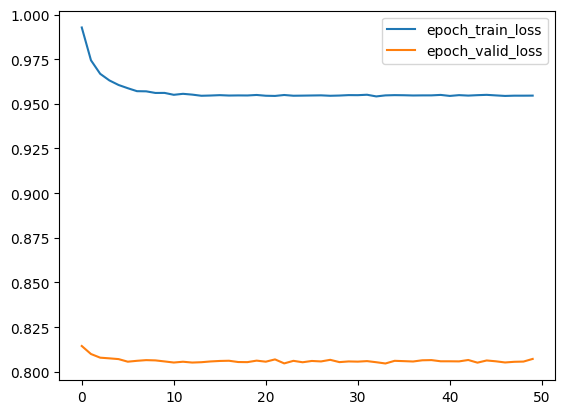

In [110]:
# eval
model.load_state_dict(
    torch.load(save_path + "/epoch_" + str(best_epoch) + ".pth")
)
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset[:-timesteps_to_predict]):

    x_test = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)
    
    if timesteps_to_predict == 1:
        y_test = snapshot.y.to(device)
    else:
        y_test = y_all[test_offset+i : test_offset+i + timesteps_to_predict,:].to(device)
        

    with torch.no_grad():
        pred = model(x_test, snapshot.edge_index, snapshot.edge_attr).squeeze()
    loss += masked_mse(pred, y_test, 0.0) # mean squared error as loss

loss = loss / (i+1)
loss = loss.item()
print("Test MSE Loss: {:.4f}".format(loss))


# store training loss 
df = pd.DataFrame(training_curve_dict)
df.to_csv("training_curve.csv")


# plot training and validation loss
df.plot()

In [ ]:
from google.colab import files
files.download('training_curve.csv')
training_curve_dict["epoch_train_loss"]